# Homework 1: COVID-19 Cases Prediction (Regression)

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Import Some Packages**

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt

myseed = 42069  # set a random seed for reproducibility
np.random.seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [2]:
device = 'cuda'

# The trained model will be saved to ./models/
os.makedirs('models', exist_ok=True)

# TODO: Using 40 states & 2 tested_positive features
target_only = False

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    # optimization algorithm (optimizer in torch.optim)
    'lr': 0.001, 
    # early stopping epochs (the number epochs since your model's last improvement)
    'early_stop': 200,
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [3]:
# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# path to training data
tr_path = r'C:\Users\lab\Downloads\Dataset\COVID19_Cases_Prediction\covid.train.csv'
# path to testing data
tt_path = r'C:\Users\lab\Downloads\Dataset\COVID19_Cases_Prediction\covid.test.csv'

df = pd.read_csv(tt_path)
df.shape

(893, 94)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [4]:
class COVID19Dataset(Dataset):
    def __init__(self,
                 path,
                 mode='train'):
        '''
        @mode: ['train', 'dev', 'test'], train和dev有label, test没有label
        '''
        self.mode = mode

        # Read data into numpy arrays
        df = pd.read_csv(path)
        data = df.iloc[:, 1:].values


        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, :-1]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        # self.data[:, 40:] = \
        #     (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
        #     / self.data[:, 40:].std(dim=0, keepdim=True)

        print(f'Finished reading the {mode} set of COVID19 Dataset ({len(self.data)} samples found, each dim = {self.data.shape[1]})')

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in 'test':
            # For testing (no target)
            return self.data[index]
        else:
            # For training
            return self.data[index], self.target[index]
        
    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [5]:
def prep_dataloader(path, mode, batch_size):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False, pin_memory=True)
    return dataloader

In [6]:
tr_set = prep_dataloader(
    tr_path, 'train', config['batch_size'])
dv_set = prep_dataloader(
    tr_path, 'dev', config['batch_size'])
tt_set = prep_dataloader(
    tt_path, 'test', config['batch_size'])

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [7]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(93, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

def loss(pred, target):
    ''' Calculate loss '''
    # Mean squared error loss
    criterion = nn.MSELoss(reduction='mean')
    return criterion(pred, target)

# **Train/Dev/Test**

## **Validation**

In [8]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        # move data to device (cpu/cuda)
        x, y = x.to(device), y.to(device)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    # compute averaged loss
    total_loss = total_loss / len(dv_set.dataset)

    return total_loss

## **Training**

In [9]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), config['lr'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print(f'Saving model (epoch = {epoch + 1:4d}, loss = {min_mse:.4f})')
            # Save model to specified path
            torch.save(model.state_dict(), config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print(f'Finished training after {epoch} epochs')
    return min_mse, loss_record

## **Testing**

In [10]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Start Training!**

In [11]:
model = NeuralNet().to(device)  # Construct model and move to device
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 43.4075)
Saving model (epoch =    3, loss = 42.3514)
Saving model (epoch =    5, loss = 37.5022)
Saving model (epoch =    6, loss = 33.7604)
Saving model (epoch =    7, loss = 31.4914)
Saving model (epoch =    8, loss = 28.8046)
Saving model (epoch =    9, loss = 25.3274)
Saving model (epoch =   10, loss = 23.2433)
Saving model (epoch =   11, loss = 21.4268)
Saving model (epoch =   12, loss = 20.0799)
Saving model (epoch =   13, loss = 17.0725)
Saving model (epoch =   14, loss = 15.7249)
Saving model (epoch =   15, loss = 13.9915)
Saving model (epoch =   16, loss = 12.8929)
Saving model (epoch =   17, loss = 11.8153)
Saving model (epoch =   18, loss = 11.1607)
Saving model (epoch =   19, loss = 10.3221)
Saving model (epoch =   21, loss = 9.3596)
Saving model (epoch =   23, loss = 8.6456)
Saving model (epoch =   24, loss = 8.5815)
Saving model (epoch =   25, loss = 8.2053)
Saving model (epoch =   26, loss = 7.9018)
Saving model (epoch =   28, loss = 7.

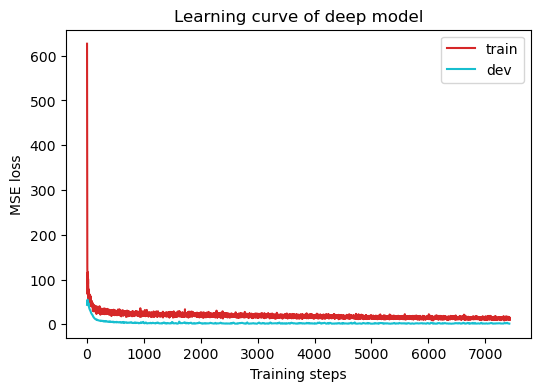

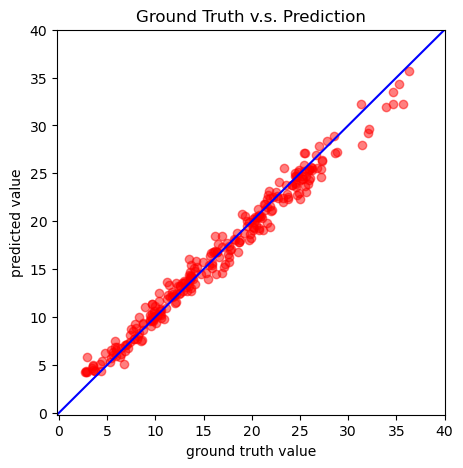

In [17]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=40., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    plt.figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()
    
plot_learning_curve(model_loss_record, title='deep model')

plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [13]:
del model
model = NeuralNet().to(device)
# Load your best model
ckpt = torch.load(config['save_path'], map_location='cpu')
model.load_state_dict(ckpt)

<All keys matched successfully>

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [14]:
preds = test(tt_set, model, device)  # predict COVID-19 cases with your model

In [15]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w', encoding='utf-8', newline='') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
            
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
